## Exploratory Data Analysis (EDA)

Goal - Create a similarity metric based on just the numerical data (elevation gain, distance, star rating)

###  Import essential modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import string
import re

# Similarity measures
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, linear_kernel
from scipy.spatial.distance import cdist

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder ,LabelBinarizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.summarization import keywords

### READ IN PICKLE DATA FILE

In [2]:
#Read in pickle data file
df=pd.read_pickle('../data/alltrails_ontario.pkl')

###  Curate dataset

#### 1. Remove nan from elevation data

In [3]:
#Replace nan with 0. - I had to do this since elevation had a few rows with nan
df.loc[np.isnan(df['elevation'])|(df['elevation']<0.1), 'elevation'] = 1

#### 2. Remove rows with no reviews

In [4]:
# Convert nreviews to int
nreviews = df.nreviews.astype('int64')
df['numreviews'] = nreviews

# type(pd.to_numeric(nreviews))
df = df[df['numreviews'] > 1]
df=df[df['review'] != '']
# df['nreviews']
# df.shape
# df.iloc[1001]

In [5]:
df['review'].iloc[150]

'Hard packed/fine gravel path for the most part. Good for bicyclist too. The trail follows a small creek for a good part. Nice enough walk for a bit of relaxation but can be noisy in some spots due to the urban environment.\n\nJust a couple of notes.  \n\nThis trail is marked April to October but considering it\'s hard-packed with crushed limestone there\'s no reason in my mind that it can\'t be used year round.  I\'m sure the locals do.\n\nI don\'t see any reason why a wheelchair can\'t access this trail.  It is somewhat hilly at points but there are no other obstacles that I would think to be an impediment.First hike with my three kids under 6 years old. Great walk with a stop at the creek to look for toads , then some wildflower picking and pretending to exercise on the equipment placed on parts of the trail. Fun!Had a nice quick hike here today, a hidden gem for sure, nice easy trails.. Very family friendlyThis trail is different than the other "Sheppard\'s Bush trail" in allmaps a

In [6]:
# df['log_distance'].shape

####  3. Create new column with trail names in lowercase

In [7]:
df['trailName']=df['name'].str.lower()
# df.head()

#### 4. Curate trail attributes

a) Curate trail attributes of interest for further analyses

In [8]:

# trail_attributes=df.trail_attributes
# hattrib=[]
# for l1 in trail_attributes:
#     hattrib.append([l2.replace(' ', '') for l2 in l1])
# print (hattrib[0])

# # Add the curated attibutes as a new column ('tagstr') in df
# df['tagstr']=pd.Series(hattrib)
# df['tagstr']=[' '.join(tag) for tag in df.tagstr.values]
# df.head(2)

#####  Create unique trail attributes

In [9]:
# Get list of unique trail attributes
tags = df.trail_attributes
unique_tags= pd.Series([tag for tags in df.trail_attributes for tag in tags]).unique()

In [10]:
unique_tags = ['dogs on leash', 'wheelchair friendly', 'kid friendly', 'stroller friendly'
 'hiking', 'mountain biking', 'nature trips', 'snowshoeing', 'trail running'
 'walking', 'forest', 'paved', 'views', 'snow', 'cross country skiing'
 'fishing', 'horseback riding', 'bird watching', 'lake', 'river', 'waterfall'
 'wild flowers', 'wildlife', 'rocky', 'bugs', 'muddy', 'beach', 'road biking'
 'dog friendly', 'scramble', 'camping', 'rock climbing', 'cave', 'skiing'
 'partially paved', 'no dogs', 'paddle sports', 'over grown', 'rails trails'
 'backpacking', 'washed out', 'off road driving', 'off trail', 'bridge out'
 'city walk', 'historic site', 'blowdown', 'no shade', 'scenic driving'
 'private property', 'closed']
# print (type(unique_tags))

##### Create curated list of tags - remove unwanted tags and add results to new column in Dataframe

In [11]:
# Create a curated list of tags - remove unwanted tags
wanted_tags = ['dogs on leash', 'wheelchair friendly', 'kid friendly',
 'hiking', 'mountain biking', 'trail running', 'forest', 
 'fishing', 'horseback riding', 'bird watching', 'lake', 'river', 'waterfall',
 'wild flowers', 'wildlife', 'rocky', 'beach',
 'dog friendly', 'scramble', 'camping', 'rock climbing', 'cave', 
 'paddle sports', 'backpacking']
# print (type(wanted_tags))

curated_tags = tags.apply(lambda tag: [el for el in tag if el in wanted_tags])
df['curated_tags'] = curated_tags
# df.head()

In [12]:
# curated_tags
df['tagstr'] = curated_tags.apply(lambda tag: [el.replace(' ', '') for el in tag])
df.shape

(847, 13)

In [13]:
# Optional (I did this before saving the curated file below - 2018-02-08) - Remove the original 'nreviews' column 
# df.pop('nreviews')
# df.head()

## ANALYSES

###  cosine similarity of curated tags

In [14]:
# Create cosine similarity metric based on tag strings
tcv=CountVectorizer()
df['tagstr']=[' '.join(tag) for tag in df.tagstr.values]
tcv_mat=tcv.fit_transform(df['tagstr'])

## Save the vectorizer vocabulary using pickle
pickle.dump(tcv.vocabulary_,open("tags_vocab_cv.pkl","wb"))

print (tcv.vocabulary_)
# Create cosine similarity matrix
cosine_sim_tagstrcv = cosine_similarity(tcv_mat,tcv_mat)

{'dogsonleash': 6, 'wheelchairfriendly': 21, 'kidfriendly': 11, 'hiking': 9, 'mountainbiking': 13, 'trailrunning': 19, 'forest': 8, 'fishing': 7, 'horsebackriding': 10, 'birdwatching': 2, 'lake': 12, 'river': 15, 'waterfall': 20, 'wildflowers': 22, 'wildlife': 23, 'rocky': 17, 'beach': 1, 'dogfriendly': 5, 'scramble': 18, 'camping': 3, 'rockclimbing': 16, 'cave': 4, 'paddlesports': 14, 'backpacking': 0}


###  cosine similarity metric of difficulty category

In [15]:
# Create cosine similarity metric based on trail difficulty used as category
df['difficulty'].astype('category')
# data
lb=LabelBinarizer()
lb_diffic=lb.fit_transform(df['difficulty'])

cosine_sim_diffic = cosine_similarity(lb_diffic,lb_diffic)
# len(cosine_sim_diffic[0])

### Reverse mapping of indices with corresponding trail names

In [16]:
# Reverse map ofindices with corresponding trail names
trail_indices=pd.Series(df.index, index=df['name']).drop_duplicates()
len(trail_indices)
# trail_indices

847

### Robustscaling of numerical features (distance, elevation)

#### Look at log of distance and elevation (due to the long tails)

C:\Users\chtra\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(847,)

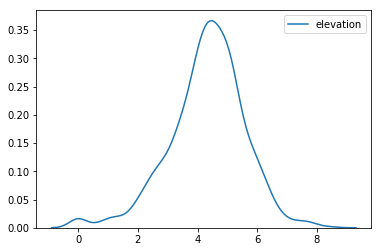

In [17]:
# Testing numerical data
elev=df['elevation']
#Natural log of elevation
log_elev=np.log(elev)
df['log_elevation']=log_elev
sns.kdeplot(log_elev)
# data.head(5)
log_elev.shape

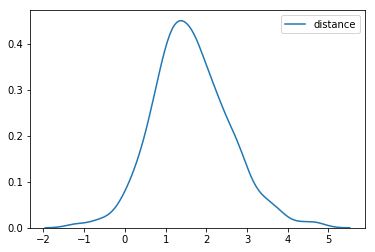

In [18]:
dist=df['distance']
log_dist=np.log(dist)
log_dist
df['log_distance']=log_dist
sns.kdeplot(log_dist)
# data.head(2)

###  cosine similarity metric for numerical data

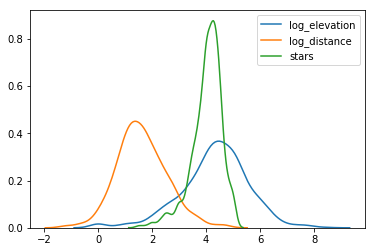

In [19]:
num_data=df[['log_elevation','log_distance','stars']]
sns.kdeplot(df['log_elevation'])
sns.kdeplot(df['log_distance'])
sns.kdeplot(df['stars'])
# num_data['log_elevation']

#####  RobustScaling for the three numerical features

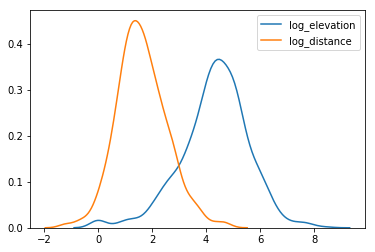

In [29]:
num_data2=df[['log_elevation','log_distance']]
sns.kdeplot(df['log_elevation'])
sns.kdeplot(df['log_distance'])
# num_data['log_elevation']

C:\Users\chtra\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


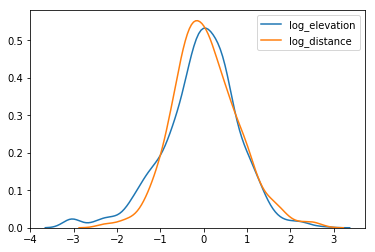

In [30]:
# Robust scaling for numerical data
scaler=RobustScaler()
# scaler=StandardScaler()
scaled_numdata2=scaler.fit_transform(num_data2)
scaled_numdata2=pd.DataFrame(scaled_numdata2, columns=['log_elevation', 'log_distance'])
sns.kdeplot(scaled_numdata2['log_elevation'])
sns.kdeplot(scaled_numdata2['log_distance'])

C:\Users\chtra\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(847, 3)

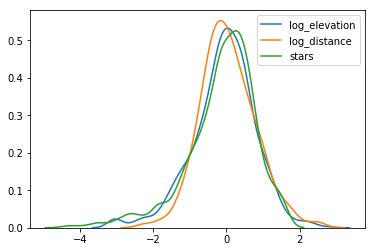

In [31]:
# Robust scaling for numerical data
scaler=RobustScaler()
# scaler=StandardScaler()
scaled_numdata=scaler.fit_transform(num_data)
scaled_numdata=pd.DataFrame(scaled_numdata, columns=['log_elevation', 'log_distance', 'stars'])
sns.kdeplot(scaled_numdata['log_elevation'])
sns.kdeplot(scaled_numdata['log_distance'])
sns.kdeplot(scaled_numdata['stars'])
scaled_numdata.shape

In [32]:
cosine_sim_num = cosine_similarity(scaled_numdata, scaled_numdata)

###  Create cosine similarity based on all features

In [33]:
# Cosine similarity for numerical data
scaled_numdata2.shape
cosine_sim_num2 = cosine_similarity(scaled_numdata2, scaled_numdata2)
cosine_sim_num2c = cosine_similarity(scaled_numdata2, scaled_numdata2)
cosine_sim_num2[0], cosine_sim_num2c[1]
cosine_sim_num2c.shape
cosine_sim_num2c

array([[ 1.        ,  0.95963293, -0.38933946, ..., -0.48661871,
         0.96288753,  0.64585833],
       [ 0.95963293,  1.        , -0.11456015, ..., -0.71268418,
         0.8481069 ,  0.83451346],
       [-0.38933946, -0.11456015,  1.        , ..., -0.61522147,
        -0.6234962 ,  0.45175804],
       ...,
       [-0.48661871, -0.71268418, -0.61522147, ...,  1.        ,
        -0.23276796, -0.98125407],
       [ 0.96288753,  0.8481069 , -0.6234962 , ..., -0.23276796,
         1.        ,  0.41582955],
       [ 0.64585833,  0.83451346,  0.45175804, ..., -0.98125407,
         0.41582955,  1.        ]])

In [34]:
#Combined features where only distance and elevation are used for the numerical data
combined_features_sim2=np.concatenate([cosine_sim_tagstrcv, cosine_sim_diffic, cosine_sim_num], axis=1)
print (combined_features_sim2.shape)

#Calculate similarity matrix for combined features
cosine_sim_allfeat2=cosine_similarity(combined_features_sim2, combined_features_sim2)
print (cosine_sim_allfeat2[0][:10])
print (cosine_sim_allfeat2.shape)

(847, 2541)
[1.         0.51559304 0.45511104 0.35434122 0.2660764  0.2729572
 0.78231394 0.32052085 0.22510317 0.02566085]
(847, 847)


In [35]:
np.savetxt('cosine_sim2-0919.dat', cosine_sim_allfeat2)

In [36]:
#Combined features where stars, distance and elevation are used for the numerical data
print (cosine_sim_tagstrcv.shape, cosine_sim_diffic.shape, cosine_sim_num.shape)
combined_features_sim3=np.concatenate([cosine_sim_tagstrcv, cosine_sim_diffic, cosine_sim_num], axis=1)
combined_features_sim3.shape

#Calculate similarity matrix for combined features
cosine_sim_allfeat3=cosine_similarity(combined_features_sim3, combined_features_sim3)
type(cosine_sim_allfeat3)

(847, 847) (847, 847) (847, 847)


numpy.ndarray

##  Write cosine similarity based on all features into a pickle file

In [37]:
np.savetxt('cosine_sim3.dat', cosine_sim_allfeat3)

###  Review text vectorization to extract keywords

In [38]:
def preprocess(text):
    words=[word for sentence in sent_tokenize(text) for word in word_tokenize(sentence)]
    words=[word for word in words if len(word)>3]
    words=[word for word in words if word not in gensim.parsing.preprocessing.STOPWORDS]
    words=[WordNetLemmatizer().lemmatize(word) for word in words]
    #Lemmatize
#     words=[WordNetLemmatizer.lemmatize(word) for word in words]
    return words

In [39]:
reviews=df.review
#tokenize text
# reviews.apply(lambda x: x.lower())
reviews=reviews.str.lower()
reviews=reviews.str.replace('\"', '')
reviews=reviews.str.replace("\'", '')
reviews=reviews.str.replace('\"', '')
reviews=reviews.str.replace('\!', '')
reviews=reviews.str.replace('\/', ' ')
reviews=reviews.str.replace(',', '')
reviews=reviews.str.replace('(', '')
reviews=reviews.str.replace(')', '')
reviews=reviews.str.replace('.', '')
reviews=reviews.str.replace('\d+', '')
reviews=reviews.replace(to_replace={'hik', 'walk','run','trail', 'interesting',\
                                    'good','great','lot','recommend','area','park',\
                                    'love','like','way','easy', 'try', 'path', 'little', \
                                    'complete', 'definite', 'clear', 'close' \
                                    'fortunately', 'ing ', 'highly', 'place', 'start' \
                                    'hour', 'closed', 'condition', 'ers'
                                   }, value='', regex=True)

rv=[word for word in reviews if len(word)>3]
# print (rv[0])
processed_text=[preprocess(text) for text in rv]
# print (processed_text[0])
# WordNetLemmatizer.lemmatize('are')

processed_text_stemmed = [PorterStemmer().stem(rev) for rev in reviews]
text_stemmed_lemmatized=[WordNetLemmatizer().lemmatize(text) for text in processed_text_stemmed]
print (reviews.shape)

(847,)


### Create keywords for reviews for each trail

In [40]:
# text_stemmed_lemmatized[0]
def get_unique_keywords(txt):
    return (set([WordNetLemmatizer().lemmatize(txt) for txt in keywrds.split()]))

In [41]:
review_keywords=[]
for i,n in enumerate(text_stemmed_lemmatized):
    keywrds = (keywords(n, ratio=0.10, lemmatize=True)) #.replace('\n', ' ')
    tx = [word for word in keywrds.split() if len(word) >2]
    if (tx != ''):
        review_keywords.append(tx)
    else:
        review_keywords.append([''])

In [42]:
print (len(review_keywords))

847


In [43]:
df['review_keywords']=pd.Series((v for v in review_keywords))
df['review_keywords1']=pd.Series(([' '.join (v)] for v in review_keywords))
# for v in review_keywords:
#     print (v)
# df.head()
rv = pd.Series([', '.join (v)] for v in review_keywords)
rv.iloc[0]

['bike, nice, dog']

In [47]:
df.head(10)

,difficulty,distance,elevation,name,nreviews,review,route_type,stars,trail_attributes,numreviews,trailName,curated_tags,tagstr,log_elevation,log_distance,review_keywords,review_keywords1
0,MODERATE,5.6,32.0,Taylor Creek Trail,23,"Great for strollers, bikes etc. Opposite side ...",Out & Back,3.7,"[dogs on leash, wheelchair friendly, kid frien...",23,taylor creek trail,"[dogs on leash, wheelchair friendly, kid frien...",dogsonleash wheelchairfriendly kidfriendly hik...,3.465736,1.722767,"[bike, nice, dog]",[bike nice dog]
1,MODERATE,4.7,64.0,Hilton Falls Trail,238,What a gem! I was so pleasantly surprised by ...,Loop,4.3,"[dogs on leash, cross country skiing, fishing,...",238,hilton falls trail,"[dogs on leash, fishing, hiking, horseback rid...",dogsonleash fishing hiking horsebackriding mou...,4.158883,1.547563,"[nice, family, fall, waterfalls, entrances, pi...",[nice family fall waterfalls entrances picnic ...
2,MODERATE,2.3,100.0,Niagara Glen Trail,135,Beautiful area with several trails. Loved exp...,Loop,4.7,"[dogs on leash, kid friendly, hiking, nature t...",135,niagara glen trail,"[dogs on leash, kid friendly, hiking, forest, ...",dogsonleash kidfriendly hiking forest river,4.605170,0.832909,"[views, stairs, nice, fall, niagara, rock, sce...",[views stairs nice fall niagara rock scenery f...
3,MODERATE,7.2,128.0,Nassagaweya and Bruce Trail Loop from Rattlesn...,170,Great views! We went in January so there weren...,Loop,4.2,"[dogs on leash, kid friendly, hiking, nature t...",170,nassagaweya and bruce trail loop from rattlesn...,"[dogs on leash, kid friendly, hiking, trail ru...",dogsonleash kidfriendly hiking trailrunning fo...,4.852030,1.974081,"[beautiful, view, nice, day, bruce, moderately...",[beautiful view nice day bruce moderately leve...
4,MODERATE,15.3,427.0,Lion's Head Loop Via Bruce Trail,117,Amazing trail with stunning lookouts. Hiked it...,Loop,4.8,"[dogs on leash, hiking, nature trips, walking,...",117,lion's head loop via bruce trail,"[dogs on leash, hiking, bird watching, beach, ...",dogsonleash hiking birdwatching beach forest w...,6.056784,2.727853,"[view, long, day, beautiful, rocks, water, you...",[view long day beautiful rocks water youre loo...
5,MODERATE,8.0,222.0,Forks of the Credit and Cataract Falls via Bru...,124,Hiking this trail for 25 years. Loveliest in t...,Loop,4.4,"[dogs on leash, hiking, nature trips, trail ru...",124,forks of the credit and cataract falls via bru...,"[dogs on leash, hiking, trail running, bird wa...",dogsonleash hiking trailrunning birdwatching l...,5.402677,2.079442,"[falls, worth, weekends, theres, dominion, nor...",[falls worth weekends theres dominion north ac...
6,MODERATE,2.9,71.0,Dundas Peak via Bruce Trail and BT Side Trail,82,"Love this trail. Great for all ages, just be c...",Loop,4.1,"[dogs on leash, hiking, road biking, trail run...",82,dundas peak via bruce trail and bt side trail,"[dogs on leash, hiking, trail running, bird wa...",dogsonleash hiking trailrunning birdwatching f...,4.262680,1.064711,"[fall, view, busy, beautiful, experience, peak...",[fall view busy beautiful experience peak best...
7,MODERATE,9.5,197.0,Dundas Valley Trail,94,winter wonderlandGreat view in fallExcellent t...,Loop,4.5,"[dogs on leash, kid friendly, hiking, mountain...",94,dundas valley trail,"[dogs on leash, kid friendly, hiking, mountain...",dogsonleash kidfriendly hiking mountainbiking ...,5.283204,2.251292,"[beautiful, nice, incredible, pretty, steep, k...",[beautiful nice incredible pretty steep kidsi ...
8,MODERATE,7.2,259.0,The Crack Trail,128,"Did this hike mid December, about of Foot of s...",Out & Back,4.8,"[dog friendly, fishing, hiking, nature trips, ...",128,the crack trail,"[dog friendly, fishing, hiking, trail running,...",dogfriendly fishing hiking trailrunning birdwa...,5.556828,1.974081,"[views, difficult, rock, nice, hard, worth, st...",[views difficult rock nice hard worth steep ab...
9,EASY,9.0,301.0,McCarston's Lake Trail via Carriage and Spillw...,133,Was 

In [45]:
# df.review_keywords.iloc[0]

##  Write curated data file to be called in the Dash app

In [46]:
df.to_pickle('../data/alltrails_ontario_curated_0208.pkl')